In [ ]:
%matplotlib inline


# Spatial Transformer Networks Tutorial

Bu notebook üzerinden uzamsal dönüştürücü adı verilen görsel bir dikkat mekanizması olan bir ağ modeli ile ağımızı nasıl genişleteceğimizi göreceğiz. Uzamsal transformatör hakkında daha fazla bilgi [DeepMind makalesinde](https://arxiv.org/abs/1506.02025) 'den kontrol edebilirsiniz.
Spatial Transformer Networks'ler ( kısaca STN'ler ), farklılaştırılabilir bir genelleştirmedir ve bir sinir ağının uzamsal performansı nasıl gerçekleştireceğini öğrenmesine izin verir. İlgilenilen bir bölgeyi kırpabilir, ölçeklendirebilir ve düzeltebilir. Bu durum yararlı olabilir. Çünkü CNN'ler veri zenginleştirmede kullanabiliriz.



In [1]:
# bazı paketleri import edelim
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

plt.ion()   # interactive mode

## Verimizi yükleyelim.
Bu yazıda klasik MNIST veri setiyle deneyler yapacağız.STN kullanarak zenginleştirilmiş standart evrişimli ağ kurmayı deneyeceğiz. Hadi elimizi taşın altına koyalım.



In [2]:
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# train dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='.', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## STN'ler hakkında biraz daha bilgi..

STN'ler üç ana bileşene dayanır :

-  `Localization network:` Normal bir CNN yapısıdır. 
-  `Grid generator:` Gİrişte bir koordinat ızgarası oluşturulur. Çıktı görüntüsünden her piksele karşılık gelen görüntü için.
-  `Sampler:` Giriş görüntüsüne öğrenilen dönüşüm parametresini uygular.

Not: affine_grid ve grid_sample modüllerini içeren en son pytorch sürümüne ihtiyacımız olacaktır. Eğer local bir makinede bu testi yapıyorsanız pip install ile indirin. 




In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # STN
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # STN için forward algoritması
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # girişi dönüştürelim
        x = self.stn(x)

        # forward tekrardan.
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)


model = Net().to(device)

## Modelimizi eğitelim.

Şimdi modeli eğitmek için SGD algoritmasını kullanalım. Ağ
sınıflandırma görevinin denetimli bir şekilde öğrenecek.. Aynı zamanda
model, STN'yi otomatik olarak uçtan uca öğreniyor.



In [4]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
#
# MNIST üzerindeki STN performanslarını ölçmek için basit bir test prosedürü.
#


def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # toplu iş kaybını özetle
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # maksimum günlük olasılığının dizinini al
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Ortalama Kayıp: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

## STN sonuçlarını görselleştirelim.


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4227: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.287663
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.887815


/usr/local/lib/python3.8/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Ortalama Kayıp: 0.2086, Accuracy: 9417/10000 (94%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.654546
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.410660

Test set: Ortalama Kayıp: 0.1790, Accuracy: 9476/10000 (95%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.317571
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.276250

Test set: Ortalama Kayıp: 0.1422, Accuracy: 9592/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.402897
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.177016

Test set: Ortalama Kayıp: 0.0773, Accuracy: 9783/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.212129
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.106460

Test set: Ortalama Kayıp: 0.0753, Accuracy: 9771/10000 (98%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.113259
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.066722

Test set: Ortalama Kayıp: 0.0614, Accuracy: 9835/10000 (98%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.111055
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.105212

Test set: Ortalama Kayıp: 0.0574, Accuracy: 9824/10

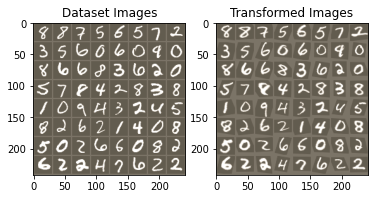

In [5]:
def convert_image_np(inp):
    """elde ettiğimiz tensörümüzü numpy dizisine dönüştürelim."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


def visualize_stn():
    with torch.no_grad():
        # bir dizi eğitim verisi alalım
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Sonuçları yan yana çizin
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Bazı giriş yığınlarında STN dönüşümünü görselleştirin
visualize_stn()

plt.ioff()
plt.show()